In [1]:
import os
import cv2
import sys
import timm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch import nn
from tqdm import tqdm
from skimage import io
from pathlib import Path
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# serve per ricaricare automaticamente il codice modificato
%load_ext autoreload
%autoreload 2

In [3]:
# directory da dove vengono prelevate le immagini
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "taming_transformer")

# per far funzionare il modello su immagini rgb o in scala di grigi (per usare fourier)
mode="rgb"

BATCH_SIZE = 32

LR = 0.001

EPOCHS = 5

DEVICE = "cuda"

In [4]:
csv_path = os.path.join("..", "datasets", "out.csv")
df = pd.read_csv(csv_path)

df = df.sample(frac=1)

df.head()

train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

print(f"train dataset size: {len(train_df)}")
print(f"val dataset size: {len(valid_df)}")

train dataset size: 40000
val dataset size: 10000


In [5]:
# carica le immagini nel dataset
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    if mode == "rgb":
      # le immagini Anchor sono memorizzate in due dataset diversi
      if str(row.Anchor).startswith("coco"):
        A_img = io.imread(os.path.join(real_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(real_data_dir, row.Positive))
        N_img = io.imread(os.path.join(fake_data_dir, row.Negative))

      else:
        A_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(fake_data_dir, row.Positive))
        N_img = io.imread(os.path.join(real_data_dir, row.Negative))

      # normalizzazione per immagini in rgb 
      A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
      P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
      N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    if mode == "grey_scale":
      A_img = np.expand_dims(A_img, 0)
      P_img = np.expand_dims(P_img, 0)
      N_img = np.expand_dims(N_img, 0)
      
      A_img = torch.from_numpy(A_img) / 255.0
      P_img = torch.from_numpy(P_img) / 255.0
      N_img = torch.from_numpy(N_img) / 255.0

    # A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    # P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    # N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [6]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"trainset size: {len(trainset)}")
print(f"validset size: {len(validset)}")

trainset size: 40000
validset size: 10000


In [7]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [8]:
print(f"#batches in trainloader : {len(trainloader)}")
print(f"#batches in validloader : {len(validloader)}")

#batches in trainloader : 1250
#batches in validloader : 313


In [9]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [10]:
model = APN_Model()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act)

In [11]:
# funzione di train
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  # on dropout 
  total_loss = 0.0

  for A, P, N in tqdm(dataloader, desc="model training..."):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    optimizer.zero_grad()

    # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    # criterion è la funzione di loss triplet
    loss = criterion(A_embs, P_embs, N_embs)
    loss.backward()
    
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [12]:
# funzione di evaluation
def eval_fn(model, dataloader, criterion):
  model.eval() 
  # off dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader, desc="model validating..."):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [13]:
# triplet loss e adam
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [14]:
# training
best_valid_loss = np.Inf

training_epoch_loss = []
validation_epoch_loss = []

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  training_epoch_loss.append(train_loss)
  validation_epoch_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("successful weights saving...")

  print(f"epochs: {i+1}, train_loss: {train_loss}, valid_loss: {valid_loss}")

model training...:   0%|          | 0/1250 [00:00<?, ?it/s]c:\Users\raffa\anaconda3\envs\fvab\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
model validating...: 100%|██████████| 313/313 [13:23<00:00,  2.57s/it]


successful weights saving...
epochs: 1, train_loss: 0.8697069536447525, valid_loss: 0.8919039951345791


model validating...: 100%|██████████| 313/313 [16:38<00:00,  3.19s/it]


successful weights saving...
epochs: 2, train_loss: 0.8116806059777737, valid_loss: 0.7356613106049669


model validating...: 100%|██████████| 313/313 [16:04<00:00,  3.08s/it]


epochs: 3, train_loss: 0.8427491829335689, valid_loss: 0.7561426434082726


model validating...: 100%|██████████| 313/313 [04:23<00:00,  1.19it/s]


epochs: 4, train_loss: 0.7748904492855072, valid_loss: 0.7477000158625289


model validating...: 100%|██████████| 313/313 [02:52<00:00,  1.81it/s]


successful weights saving...
epochs: 5, train_loss: 0.7766959713697433, valid_loss: 0.7125705448202432


<function matplotlib.pyplot.show(close=None, block=None)>

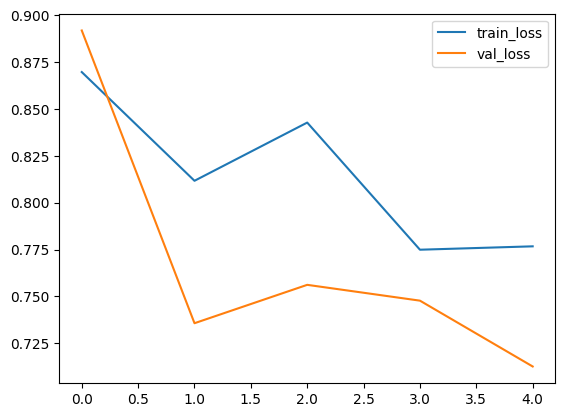

In [15]:
# plot della training e validation loss
plt.plot(training_epoch_loss, label="train_loss")
plt.plot(validation_epoch_loss, label="val_loss")
plt.legend()

plt.show

In [16]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):

      if mode == "rgb":
        # serve per trovare correttamente l'immagine
        if str(i).startswith("coco"):
          dirFolder = real_data_dir
          A = io.imread(os.path.join(dirFolder,i))
        else: 
          dirFolder = fake_data_dir
          A = io.imread(os.path.join(dirFolder,i))

        A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      
      if mode == "grey_scale":
        A = io.imread(os.path.join(dirFolder,i))

        A = np.expand_dims(A, 0)
        A = torch.from_numpy(A.astype(np.int32)) / 255.0
        
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [17]:
# per ricaricare il modello una volta allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati
df_enc = get_encoding_csv(model, df["Anchor"], real_data_dir)

df_enc.to_csv("database.csv", index=False)

100%|██████████| 50000/50000 [14:13<00:00, 58.58it/s]


In [18]:
df_enc = pd.read_csv('database.csv')
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,tt-coco/samples_nopix/img000134.jpg,-0.212294,0.006088,-0.007298,0.021387,0.053470,0.045112,0.118424,-0.069691,0.388697,...,-0.119996,0.163988,0.026037,0.043263,0.004905,0.055207,0.043948,-0.002747,-0.100684,-0.016454
1,coco/coco2017/test2017/img025819.jpg,-0.214148,0.005716,-0.008460,0.022555,0.053427,0.043677,0.120083,-0.070621,0.336749,...,-0.120422,0.166182,0.025989,0.043530,0.006345,0.055137,0.042749,-0.003541,-0.100376,-0.015560
2,coco/coco2017/train2017/img075676.jpg,-0.217998,0.006955,-0.006917,0.019181,0.053968,0.049383,0.116525,-0.069693,0.563114,...,-0.122417,0.165995,0.028850,0.047130,0.000408,0.057033,0.048602,-0.006214,-0.104048,-0.017752
3,tt-cc/cin_k600_p1.0_a0.05_fid5.20/616/img02877...,-0.217750,-0.005783,-0.013311,0.033562,0.041199,0.039579,0.138679,-0.079598,-0.129211,...,-0.111223,0.180442,0.009950,0.049785,0.024157,0.049309,0.019246,0.001448,-0.087686,0.003513
4,tt-ffhq/ffhq_k300_p1.0_fid9.6/img027529.jpg,-0.216723,-0.003790,-0.012478,0.032719,0.043111,0.040285,0.136822,-0.079459,-0.088657,...,-0.113794,0.178526,0.011781,0.049154,0.022826,0.049953,0.022968,0.001683,-0.089483,0.000247


In [19]:
# approssimazione della distanza, senza la radice quadrata, per fare i primi allenamenti velocemente
def euclidean_dist(img_enc, anc_enc_arr):
    # dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    # dist = np.sqrt(dist)
    return dist

In [20]:
path = os.path.join(Path(os.getcwd()).parent, "datasets", "testList.csv")
df = pd.read_csv(path)

print(df["real"])
print(df.size)
df.head()

0       coco/coco2017/train2017/img046326.jpg
1       coco/coco2017/train2017/img046326.jpg
2       coco/coco2017/train2017/img077760.jpg
3        coco/coco2017/test2017/img015763.jpg
4        coco/coco2017/test2017/img015763.jpg
                        ...                  
9995    coco/coco2017/train2017/img097956.jpg
9996    coco/coco2017/train2017/img121175.jpg
9997    coco/coco2017/train2017/img121175.jpg
9998    coco/coco2017/train2017/img139503.jpg
9999    coco/coco2017/train2017/img139503.jpg
Name: real, Length: 10000, dtype: object
20000


,real,fake
0,coco/coco2017/train2017/img046326.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/95/img047257...
1,coco/coco2017/train2017/img046326.jpg,tt-coco/samples_nopix/img000448.jpg
2,coco/coco2017/train2017/img077760.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img034557.jpg
3,coco/coco2017/test2017/img015763.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img038960.jpg
4,coco/coco2017/test2017/img015763.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img007393.jpg


In [21]:
def getImageEmbeddings(img, model):
    if mode == "rgb":
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
      
    if mode == "grey_scale":
        img = np.expand_dims(img, 0)
        img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [22]:
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [23]:
# DataTestReal = 'C:/Users/polsi/Desktop/Lavori/DeepFake/Datasets/Artifact/cycle_gan/st/test/'
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "taming_transformer")

y_true = []
y_pred = []

tempDf = df
tempDf.head()
tempDf.shape

(10000, 2)

In [24]:
# testo i fake
currentTest = "fake"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on fake images..."):
    path = os.path.join(fake_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)

    if mode == "rgb":
        if str(closestLabel).startswith("coco"):
            y_pred.append("real")
        else:
            y_pred.append("fake")

    if mode == "grey_scale": 
        if "real" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

testing on fake images...: 10000it [2:26:02,  1.14it/s]


In [25]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
10000
['real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake',

In [26]:
# testo i real
currentTest = "real"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on real images..."):
    path = os.path.join(real_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)
    
    if mode == "rgb":
        if str(closestLabel).startswith("coco"):
            y_pred.append("real")
        else:
            y_pred.append("fake")

    if mode == "grey_scale":
        if "real" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")


testing on real images...: 10000it [2:25:27,  1.15it/s]


In [27]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
20000
['real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake',

In [28]:
# creo i vettori di ground truth
y_true = np.array(["fake"] * len(valid_df))
print(y_true.shape)

temp = np.array(["real"] * len(valid_df))
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

(10000,)
(10000,)
(20000,)
[[4998 5002]
 [4989 5011]]


In [29]:
TN, FP, FN, TP = cm.ravel()

# metriche
accuracy = round((TP + TN) / (TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

{'Accuracy': 50.03999999999999, 'Precision': 50.03999999999999, 'Recall': 50.11, 'Specificity': 49.98, 'F1 Score': 50.075}


In [30]:
# si salvano i risultati in un file .csv
df_results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
df_results.loc[0] = [accuracy, precision, recall, specificity, f1_score]

# si differenziano i risultati in base al tipo di immagini e dataset usati
dataset = fake_data_dir.split("\\")[-1]
path = os.path.join("..", "results", "siamese_" + mode + "_" + dataset + "_results.csv")

df_results.to_csv(path, index=False)